# PyTASER Multiprocessing Example

In the following example, we use the outputs from a DFT calculation, using VASP, to generate the predicted absorption spectra under various conditions. Specifically, this requires the calculation of the orbital derivatives between electronic bands, which can be achieved using the [`LOPTICS`](https://www.vasp.at/wiki/index.php/LOPTICS) `INCAR` tag in `VASP`.

**Note:**
In order for VASP to output the necessary information for `PyTASER` to compute the full absorption spectrum under various excitation conditions, the following tags must be set in the `INCAR` file:
```
LOPTICS = True  # calculate the frequency dependent dielectric matrix
LVEL = True  # output the full interband orbital derivative information to the WAVEDER
ISYM = 0  # turn off symmetry, currently required for parsing the WAVEDER with pymatgen
```

**Multiprocessing:**
When parsing the orbital derivatives (and thus oscillator strengths) from a VASP calculation with many kpoints or bands, this can incur a lot of computational overhead and can take a while to run. To speed this processing up, we have added multiprocessing capability to `PyTASER`, which parallelises the parsing of the `WAVEDER` file across multiple cores.

## Parse DFT Outputs

### 6x6x6 kpoint mesh, CdTe

In [1]:
import time
from pytaser.generator import TASGenerator

In [2]:
tg = TASGenerator.from_vasp_outputs("CdTe/k666_Optics/vasprun.xml", "CdTe/k666_Optics/WAVEDER")

Here to show the speed of multiprocessing, we will time how long it takes to parse the `WAVEDER` file information with and without multiprocessing enabled:

In [5]:
start = time.time()
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3, processes=1)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 20736it [00:11, 1799.66it/s]                           
Calculating oscillator strengths (spin up, under illumination): 20736it [00:11, 1821.33it/s]                           


Elapsed time: 24.94 s


Using multiprocessing:

In [3]:
start = time.time()
# use default processes which is one minus the number of CPUs available:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 20736it [00:04, 4552.04it/s]                           
Calculating oscillator strengths (spin up, under illumination): 20736it [00:04, 4839.56it/s]                           


Elapsed time: 10.42 s


Here we achieve a decent speedup, going from 25 seconds to 10 seconds on a Macbook M1 Pro 2021.

### 8x8x8 kpoint mesh, CdTe

In [5]:
tg = TASGenerator.from_vasp_outputs("CdTe/k888_Optics/vasprun.xml", "CdTe/k888_Optics/WAVEDER")

If our kpoint mesh or number of bands is much larger, we expect to see much greater speedup from multiprocessing. Let's test this with a larger kpoint mesh:

In [8]:
# without multiprocessing
start = time.time()
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3, processes=1)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 149760it [07:01, 355.31it/s]                              
Calculating oscillator strengths (spin up, under illumination): 149760it [07:16, 342.89it/s]                              


Elapsed time: 913.32 s


913 seconds = 15 minutes and 13 seconds!

Using multiprocessing:

In [6]:
start = time.time()
# use default processes which is one minus the number of CPUs available:
tas = tg.generate_tas(energy_min=0, energy_max=7, temp=300, conc=1e22, cshift=1e-3)
end = time.time()
print(f"Elapsed time: {end - start:.2f} s")

Calculating oscillator strengths (spin up, dark): 149760it [01:18, 1900.47it/s]                             
Calculating oscillator strengths (spin up, under illumination): 149760it [01:19, 1872.90it/s]                            


Elapsed time: 172.96 s


Here we achieve a much greater speedup, going from 913 seconds (15 minutes) to 173 seconds (<3 minutes) on a Macbook M1 Pro 2021.

As mentioned in the main DFT example notebook, we can also save our generated TAS object to a `json` file with `monty.serialization`'s `dumpfn` function, to avoid having to re-parse the VASP files and save time when (re-)running our analysis.

In [7]:
from monty.serialization import dumpfn
dumpfn(tas, "cdte_tas.json")

## Using Supercomputers/HPCs

If you have a large number of kpoints/electronic bands and your local computer is unable to parse the `WAVEDER` file in a reasonable amount of time, you can also use `PyTASER` on a supercomputer/HPC to do this – this will take advantage of multiprocessing with the many available CPUs, and should greatly reduce the parsing time.

To do this, you can run the following python script as part of a HPC job in a directory where the `vasprun.xml` and `WAVEDER` files from the calculation you want to parse are present:

```python
#!/usr/bin/env python
from pytaser.generator import TASGenerator
from monty.serialization import dumpfn

tg = TASGenerator.from_vasp_outputs("vasprun.xml", "WAVEDER")
# choose TAS parameters (don't set processes to allow automatic multiprocessing)
tas = tg.generate_tas(energy_min=0, energy_max=10, temp=300, conc=1e22, cshift=1e-3)
dumpfn(tas, "tas.json")
```

Once this has completed, you can copy the `tas.json` file back to your local computer and use this to generate the absorption spectra with `PyTASER` as normal.

## Plotting

Let's plot the predicted TAS spectrum for this material, with our 8x8x8 kpoint mesh:

In [8]:
from monty.serialization import loadfn
tas = loadfn("cdte_tas.json")

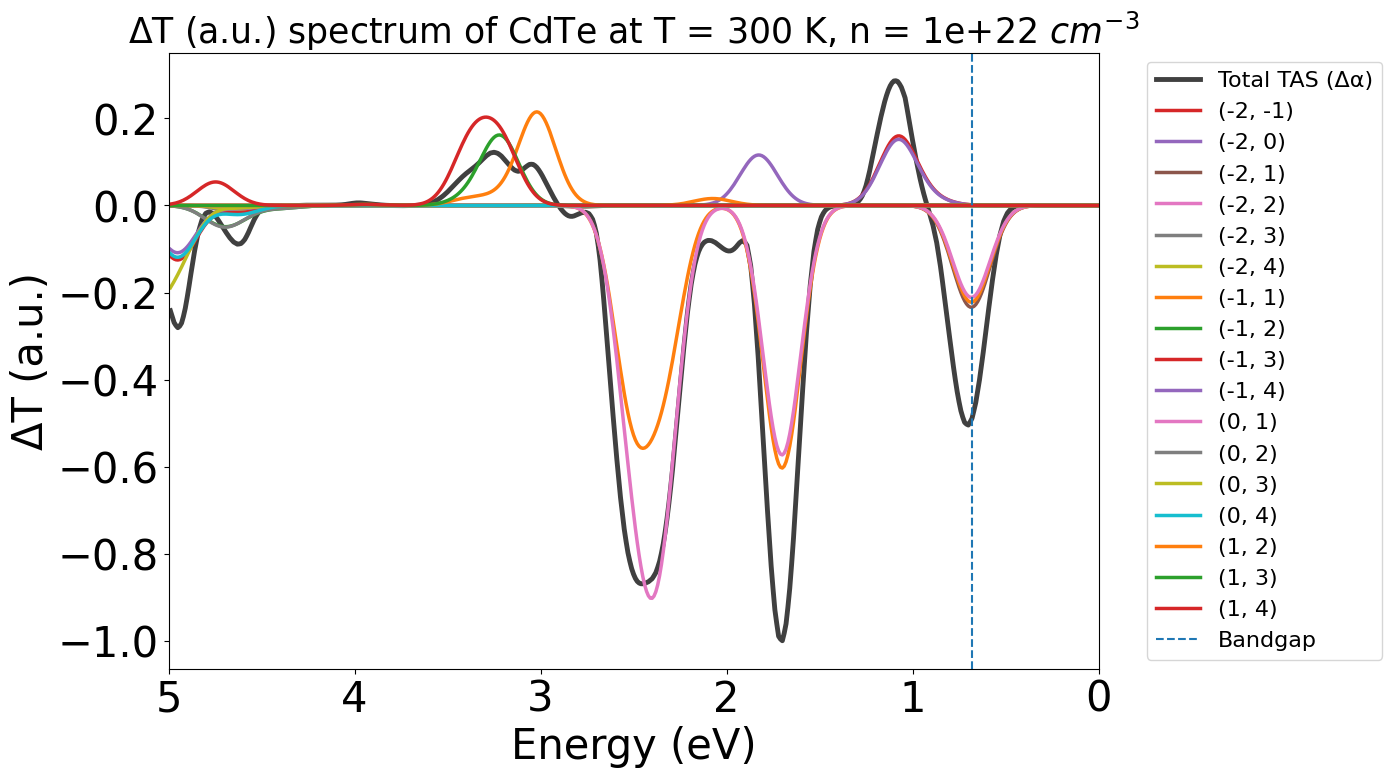

In [10]:
from pytaser.plotter import TASPlotter

plot_dft = TASPlotter(tas, material_name="CdTe")
energy_plot = plot_dft.get_plot(
    xaxis="energy", transition_cutoff=0.01, xmin=0, xmax=5, yaxis="tas")
# Reverse axis for better comparison to experiment
energy_plot.gca().invert_xaxis()